### 1.Import Packages

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix,accuracy_score
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

### 2.Import Data

In [107]:
bankloans=pd.read_csv('C:/Users/shamebanerjee/Desktop/Personal_Stuff_1/Analytics/Python/Class 21/bankloans - 1657370170610.csv')

In [108]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [109]:
bankloans.head()

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0

### 3.Separate the Data

In [110]:
# Separate 150 rows of default variable having missing value (this will be used for prediction)

bankloan_existing=bankloans.loc[bankloans.default.notna()]
bankloan_new=bankloans.loc[bankloans.default.isna()]

### 4.a) Summary of Continuous Variables 
### 4.b) Outlier Treatment

#### UDF for finding summary of Continuous variables

In [111]:
def continuous_summary(x):
    #Missing value
    n_total=x.shape[0]
    n_miss=x.isna().sum()
    nmiss_percent=n_miss/n_total*100
    
    #Outliers
    q1=x.quantile(0.25)
    q3=x.quantile(0.75)
    iqr=q3-q1
    lcl=q1-1.5*iqr
    ucl=q3+1.5*iqr
    
    return pd.Series([x.dtype,x.nunique(),n_total,x.count(),n_miss,nmiss_percent,x.sum(),x.mean(),x.var(),x.std(),lcl,ucl,
              x.min(),x.quantile(0.01),x.quantile(0.05),x.quantile(0.1),x.quantile(0.25),x.quantile(0.5),x.quantile(0.75),
              x.quantile(0.90),x.quantile(0.95),x.quantile(0.99),x.max()],
             index=['Dtype','Cardinality','n_tot','n','n_miss','miss%','sum','mean','Variance','Stddev','lcl','ucl','min',
                   'p1','p5','p10','p25','p50','p75','p90','p95','p99','Max'])

In [112]:
#4.a) Summary of Continuous variables (we do not have any categorical variable so not deriving any summary)

bankloan_existing.apply(continuous_summary)

age        ed     employ    address       income  \
Dtype            int64     int64      int64      int64        int64   
Cardinality         37         5         32         31          114   
n_tot              700       700        700        700          700   
n                  700       700        700        700          700   
n_miss               0         0          0          0            0   
miss%              0.0       0.0        0.0        0.0          0.0   
sum              24402      1206       5872       5795        31921   
mean             34.86  1.722857   8.388571   8.278571    45.601429   
Variance     63.957482  0.861566  44.329483  46.578939  1355.287265   
Stddev        7.997342  0.928206   6.658039   6.824877    36.814226   
lcl               12.5      -0.5      -10.5      -10.5        -22.5   
ucl               56.5       3.5       25.5       25.5        101.5   
min                 20         1          0          0           14   
p1                21.0       1.0        0.0        0.0         15.0   
p5                23.0       1.0        0.0        0.0         17.0   
p10               25.0       1.0        1.0        1.0         19.0   
p25               29.0       1.0        3.0        3.0         24.0   
p50               34.0       1.0        7.0        7.0         34.0   
p75               40.0       2.0       12.0       12.0         55.0   
p90               46.0       3.0       18.0       18.0         82.0   
p95               49.0       4.0      21.05       22.0        113.0   
p99              53.01       4.0      27.01      26.01        190.3   
Max                 56         5         31         34          446   

               debtinc     creddebt      othdebt   default  
Dtype          float64      float64      float64   float64  
Cardinality        231          695          699         2  
n_tot              700          700          700       700  
n                  700          700          700       700  
n_miss               0            0            0         0  
miss%              0.0          0.0          0.0       0.0  
sum             7182.4  1087.486972  2140.746028     183.0  
mean         10.260571     1.553553     3.058209  0.261429  
Variance     46.611118     4.482523    10.808015   0.19336  
Stddev        6.827234     2.117197     3.287555  0.439727  
lcl            -8.6875    -1.930284    -3.274152      -1.5  
ucl            27.8125     4.201299     8.241395       2.5  
min                0.4     0.011696     0.045584       0.0  
p1                 0.9     0.030209     0.160936       0.0  
p5                 1.9     0.107029     0.376727       0.0  
p10                2.9      0.17002     0.562232       0.0  
p25                5.0     0.369059     1.044178       0.0  
p50                8.6     0.854869     1.987567       0.0  
p75             14.125     1.901955     3.923065       1.0  
p90              19.61     3.621504      7.03618       1.0  
p95               23.8     5.098264     9.501648       1.0  
p99             30.701     9.891428    17.184744       1.0  
Max               41.3     20.56131      27.0336       1.0

In [113]:
#4.b) Outlier Treatment

bankloan_existing=bankloan_existing.apply(lambda x:x.clip(upper=x.quantile(0.99),lower=x.quantile(0.01)))

### 5. Finding Out Significant variables (Somer'd) and Eliminating Multicollinearity (VIF)

In [114]:
# Finding out significance of variable using ROC_AUC score and Somer's D value

D1=pd.DataFrame()

for i in bankloan_existing.columns.difference(['default']):
    
    dummy_model_probability=smf.logit('default ~ ' + i,bankloan_existing).fit()
    
    y_pred=dummy_model_probability.predict(bankloan_existing)
    
    Roc_score=roc_auc_score(bankloan_existing.default,y_pred)
    
    SomarsD_value=2*Roc_score-1
    
    temp=pd.DataFrame([i,Roc_score,SomarsD_value]).T
    
    D1=pd.concat([D1,temp],axis=0)
    
D1.columns=['Feature','ROC_Score','SomarDvalue']
D1

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


Feature ROC_Score SomarDvalue
0   address  0.611192    0.222384
0       age  0.603165    0.206329
0  creddebt  0.636189    0.272378
0   debtinc  0.735253    0.470506
0        ed  0.574151    0.148302
0    employ  0.704569    0.409138
0    income  0.600136    0.200273
0   othdebt  0.586903    0.173806

In [115]:
#We select those Features which have somar's D score > 0.2

Features=list(D1.loc[D1.SomarDvalue>0.2,'Feature'])
Features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

In [116]:
# Check Multicollinearity
# We see VIF is less than 5 for all the variables. Hence we will consider all the variables

formula_2='default ~ ' + ' + '.join(Features)
y,x=dmatrices(formula_2,bankloan_existing,return_type='dataframe')

vif=pd.DataFrame()
vif['Features']=x.columns
vif['vif']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif

Features        vif
0  Intercept  28.286222
1    address   1.559236
2        age   2.036933
3   creddebt   2.564921
4    debtinc   1.778339
5     employ   1.997947
6     income   2.601717

<AxesSubplot:>

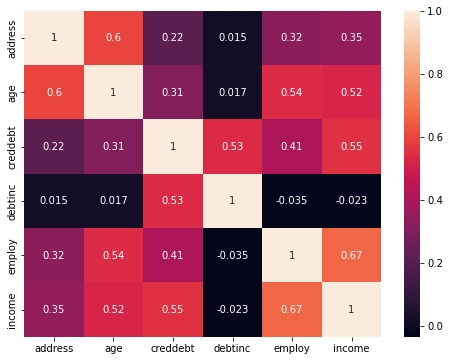

In [117]:
#Check correlations

plt.figure(figsize=(8,6))
sns.heatmap(bankloan_existing.loc[:,Features].corr(),annot=True)

### 6.a) Train Test Split
### 6.b) Model Building and fitting
### 6.c) Finding best cutoff
### 6.d) Predict Values
### 6.e) Check Accuracy

In [118]:
#6.a) Train Test Split

train, test=train_test_split(bankloan_existing,test_size=0.3,random_state=1)

In [119]:
#6.b) Model Building and fitting and predicting probability

m1=smf.logit(formula_2,train).fit()
y_predicted_proba_train=m1.predict(train)

m2=smf.logit(formula_2,test).fit()
y_predicted_proba_test=m2.predict(test)


Optimization terminated successfully.
         Current function value: 0.399179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388317
         Iterations 7


In [120]:
train_y=pd.DataFrame()
train_y=pd.concat([train.default,y_predicted_proba_train],axis=1)
train_y.columns=['y_actual','y_predicted_proba']

test_y=pd.DataFrame()
test_y=pd.concat([test.default,y_predicted_proba_test],axis=1)
test_y.columns=['y_actual','y_predicted_proba']

In [121]:
#6.c) Finding the best cutoff
train_param=pd.DataFrame()

for i in np.arange(0.00,1.01,0.01):
    
    #predicting the values
    train_predicted_value=np.where(train_y.y_predicted_proba>=i,1,0)
    
    #Finding out recall and accuracy
    
    conf_matrix=confusion_matrix(train_y.y_actual,train_predicted_value)[::-1][::-1]
    
    tp=conf_matrix[0][0]
    tn=conf_matrix[1][1]
    fp=conf_matrix[1][0]
    fn=conf_matrix[0][1]
    
    sens_tpr=tp/(tp+fn)
    accuracy=(tp+tn)/conf_matrix.sum()
    spec_tnr=tn/(fp+tn)
    s_s=sens_tpr+spec_tnr
    
    temp=pd.DataFrame([i,tp,tn,fp,fn,sens_tpr,accuracy,spec_tnr,s_s],
                      index=['i','tp','tn','fp','fn','sens_tpr','accuracy','spec_tnr','s_s']).T
    
    train_param=pd.concat([train_param,temp],axis=0)
    
train_param

i     tp     tn     fp     fn  sens_tpr  accuracy  spec_tnr       s_s
0   0.00    0.0  126.0    0.0  364.0  0.000000  0.257143  1.000000  1.000000
0   0.01   48.0  126.0    0.0  316.0  0.131868  0.355102  1.000000  1.131868
0   0.02   75.0  125.0    1.0  289.0  0.206044  0.408163  0.992063  1.198107
0   0.03   94.0  125.0    1.0  270.0  0.258242  0.446939  0.992063  1.250305
0   0.04  112.0  124.0    2.0  252.0  0.307692  0.481633  0.984127  1.291819
..   ...    ...    ...    ...    ...       ...       ...       ...       ...
0   0.96  364.0    2.0  124.0    0.0  1.000000  0.746939  0.015873  1.015873
0   0.97  364.0    0.0  126.0    0.0  1.000000  0.742857  0.000000  1.000000
0   0.98  364.0    0.0  126.0    0.0  1.000000  0.742857  0.000000  1.000000
0   0.99  364.0    0.0  126.0    0.0  1.000000  0.742857  0.000000  1.000000
0   1.00  364.0    0.0  126.0    0.0  1.000000  0.742857  0.000000  1.000000

[101 rows x 9 columns]

In [122]:
# The best cutoff is where sensitivity+Specificity is maximum

best_cutoff=train_param.loc[train_param.s_s==train_param.s_s.max(),'i'][0]
best_cutoff

0.3

In [123]:
#6.D) Predicting the values using the best cutoff

train_y['y_predicted']=np.where(train_y.y_predicted_proba>=best_cutoff,1,0)
test_y['y_predicted']=np.where(test_y.y_predicted_proba>=best_cutoff,1,0)

In [124]:
#6.E) Check Accuracy for Train and Test

print(classification_report(train_y.y_actual,train_y.y_predicted))
print(classification_report(test_y.y_actual,test_y.y_predicted))
train_accuracy=accuracy_score(train_y.y_actual,train_y.y_predicted)
test_accuracy=accuracy_score(test_y.y_actual,test_y.y_predicted)

print('Train Accuracy ',train_accuracy,' | Test Accuracy ',test_accuracy)

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.84       364
         1.0       0.56      0.79      0.65       126

    accuracy                           0.79       490
   macro avg       0.74      0.79      0.75       490
weighted avg       0.82      0.79      0.80       490

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       153
         1.0       0.56      0.77      0.65        57

    accuracy                           0.77       210
   macro avg       0.73      0.77      0.74       210
weighted avg       0.81      0.77      0.78       210

Train Accuracy  0.7857142857142857  | Test Accuracy  0.7714285714285715


### 7.Decile Analysis

In [125]:
train_y['Deciles']=pd.qcut(train_y.y_predicted_proba,10,labels=False)
test_y['Deciles']=pd.qcut(test_y.y_predicted_proba,10,labels=False)

In [126]:
train_Decile=train_y.groupby('Deciles').agg({'y_predicted_proba':['max','min'],
                                             'y_actual':['sum','count']}).reset_index().sort_values(by='Deciles',ascending=False)

test_Decile=test_y.groupby('Deciles').agg({'y_predicted_proba':['max','min'],
                                             'y_actual':['sum','count']}).reset_index().sort_values(by='Deciles',ascending=False)

In [127]:
train_Decile

Deciles y_predicted_proba           y_actual      
                        max       min      sum count
9       9          0.965061  0.663694     37.0    49
8       8          0.660805  0.477184     27.0    49
7       7          0.474690  0.348075     20.0    49
6       6          0.346853  0.245477     19.0    49
5       5          0.243886  0.183209      9.0    49
4       4          0.182665  0.118880      6.0    49
3       3          0.117884  0.061544      3.0    49
2       2          0.061508  0.031377      4.0    49
1       1          0.031213  0.010243      1.0    49
0       0          0.010123  0.000414      0.0    49

In [128]:
test_Decile

Deciles y_predicted_proba           y_actual      
                        max       min      sum count
9       9          0.995841  0.691892     20.0    21
8       8          0.688406  0.529770     13.0    21
7       7          0.528486  0.422278      3.0    21
6       6          0.401068  0.266165     10.0    21
5       5          0.265036  0.158695      5.0    21
4       4          0.157985  0.096017      1.0    21
3       3          0.095643  0.066300      4.0    21
2       2          0.063976  0.026611      1.0    21
1       1          0.025977  0.008491      0.0    21
0       0          0.007775  0.000534      0.0    21

### 8.Predict the New Data

In [136]:
bankloan_new.loc[:,'Prob']=m3.predict(bankloan_new)

bankloan_new.loc[:,'default']=np.where(bankloan_new.Prob>=best_cutoff,1,0)

bankloan_new.default.value_counts()

C:\Users\shamebanerjee\AppData\Local\Temp\ipykernel_3260\2494243303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloan_new.loc[:,'Prob']=m3.predict(bankloan_new)
C:\Users\shamebanerjee\AppData\Local\Temp\ipykernel_3260\2494243303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloan_new.loc[:,'default']=np.where(bankloan_new.Prob>=best_cutoff,1,0)


0    101
1     49
Name: default, dtype: int64

### 9. Outcome